# Modeling Performance

|  Model                |  Out Of Box AUC  |  Tuned AUC  |
|-----------------------|------------------|-------------|
|  CatBoost             |  0.8572          |  0.84513    |

After several different methodologies of trying to increase the AUC I give up! The out of box CatBoost performance is quite nice.

In [1]:
# General
import pandas as pd
import numpy as np
from time import time
from pprint import PrettyPrinter
import pickle

# Data Tools
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Models
from catboost import CatBoostClassifier

# Plotting Tools
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
%matplotlib inline
pp = PrettyPrinter()

In [2]:
df = pd.read_csv('../data/telco_churn_clean.csv')

In [3]:
# Get rid of IDs
df.drop('customerID', axis=1, inplace=True)

# Turn the target into integers and seperate
df['Churn'] = df['Churn'].replace('Yes', 1)
df['Churn'] = df['Churn'].replace('No', 0)
target = df['Churn']
df.drop('Churn', axis=1, inplace=True)

# Standardize Numerics
scaler = StandardScaler()
numer_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
numerics = df[numer_cols]
numerics = pd.DataFrame(scaler.fit_transform(numerics), columns=numer_cols)
for col in numerics:
    df[col] = numerics[col]

# Get columns which have 4 or less unique vals in them, aka the categoricals in this dataset
cat_cols = df.nunique()[df.nunique() <= 4].index.tolist()
# Get column indices (catboost only accepts a list of integers - not strings)
cat_cols = [df.columns.get_loc(col) for col in cat_cols]

# Train Test Split
train_x, test_x, train_y, test_y = train_test_split(df, target, random_state=42)

## Main Modeling Function

In [4]:
def grid_classifier(model, train, target, parameters={}, cv=5, timed=True, feat_imp=False, verbose=True):
    '''
    For tuning models.
    
    Automatically plots CV results, but this requires training over on parameter at a time.
    If the parameters argument stays an empty dictionary then no plot is made (duh...)
    
    Returns the GridSearch object
    
        Parameters:
        -----------
    model - model
    train - array of training data
    target - array of target data
    parameters - dict of parameters the GSearcher will run over
    cv - int, k-fold number
    timed - boolean, gives printout of timings
    
        Returns :
        ---------
    gsearcher - fitted and searched GridSearchCV object
    '''
    if timed:
        start = time()
    
    # Grid Search
    gsearcher = GridSearchCV(
        estimator=model, 
        param_grid=parameters,
        scoring='roc_auc',
        n_jobs=-1,
        cv=cv,
        return_train_score=True
    )
    gsearcher.fit(train, target)
    results = gsearcher.cv_results_
    
    if timed:
        passed = time() - start
        print(f'Seconds to fit: {passed:.2f}')

    if verbose:
        # Print Report
        print('Grid Scores: \n')
        pp.pprint(results)
        print(f'Best Model Parameters: {gsearcher.best_params_}')
        print(f'Best Model Score: {gsearcher.best_score_:.4f}')
    else:
        score = np.mean(results['mean_test_score'])
        print(f'AUC: {round(score, 5)}')
    
    # Plot CV Results
    if parameters:
        test_means = results['mean_test_score']
        train_means = results['mean_train_score']
        x = range(len(test_means))
        model_name = str(model.__class__).split('.')[-1][:-2]
        param = list(results['params'][0].keys())[0]
        labels = [str(pair[param]) for pair in results['params']]

        plt.figure(figsize=(10, 8))
        plt.plot(x, test_means, label='Test', color='blue')
        plt.plot(x, train_means, label='Train', color='green')
        plt.title(f'{model_name} over {param}')
        plt.xlabel(param)
        plt.ylabel('AUC Scores')
        plt.xticks(x, labels, rotation=60)
        plt.legend()
    
    # Plot Feature Importance
    if feat_imp:
        best_model = gsearcher.best_estimator_
        best_model.fit(train, target)
        feat_series = pd.Series(best_model.feature_importances_, index=train.columns)
        feat_series.sort_values(ascending=False, inplace=True)

        plt.figure(figsize=(10, 8))
        feat_series.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        plt.xticks(rotation=60)        
    
    return gsearcher

## Modeling

## Table of Contents
* Baseline
* Loss Function
* N Estimators
* Max Depth
* L2 Leaf Reg
* Border Count
* Ctr Border Count
* Learning Rate
* Final Model

### Baseline

In [6]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False
)

baseline_gsearch = grid_classifier(model, test_x, test_y, verbose=False)

Seconds to fit: 257.59
AUC: 0.8572


#### Loss Function
Stickng with the default of 'Logloss'

In [7]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 299.99
AUC: 0.84561


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a198f7908>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [8]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    loss_function='CrossEntropy'
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 330.08
AUC: 0.84561


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x105d2ebe0>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [9]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    loss_function='MultiClass'
)

grid_classifier(model, train_x, train_y, verbose=False)

Seconds to fit: 208.67
AUC: 0.84547


GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x105d2ec88>,
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

#### N Estimators

Seconds to fit: 6337.38
Grid Scores: 

{'mean_fit_time': array([ 14.46013737,  18.24491749,  22.6248703 ,  27.53230343,
        36.002356  ,  47.86353498,  50.14558692,  53.49162769,
        60.46545162,  65.30411654,  72.33591075,  78.37117295,
       101.34770894,  90.73919187,  90.32423725, 115.29663601,
       137.45513034, 111.09313288, 117.85108104, 113.31453657,
       118.51962342, 124.50829802, 129.36422157, 135.19897099,
       141.04910283, 171.6772367 , 204.9785233 , 205.8128571 ,
       194.87601609, 186.60645447, 192.39673696, 199.51108251,
       218.49431233, 227.30342207, 237.11647162, 219.28493299,
       224.15407944, 248.92645659, 214.57602868]),
 'mean_score_time': array([0.01787615, 0.01530766, 0.01502452, 0.01556072, 0.01582885,
       0.019805  , 0.01612449, 0.01629596, 0.01662383, 0.01701379,
       0.0183516 , 0.01854377, 0.01858335, 0.01676259, 0.01727891,
       0.01780391, 0.01761642, 0.01708484, 0.0174396 , 0.01739149,
       0.01746869, 0.01745038, 0.0180

GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x105d2ef60>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'n_estimators': range(50, 1001, 25)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

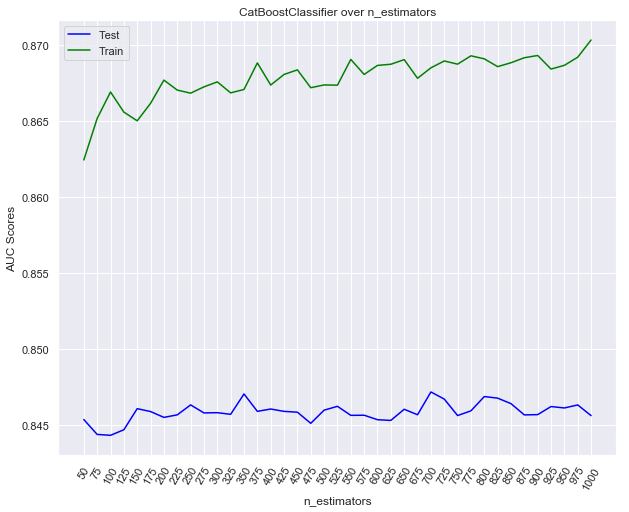

In [10]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False
)

parameters = {'n_estimators': range(50, 1001, 25)}

grid_classifier(model, train_x, train_y, parameters)

#### Learning Rate

Seconds to fit: 2116.61
Grid Scores: 

{'mean_fit_time': array([188.00010419, 252.35669317, 188.41044321, 180.09085922,
       162.82501078, 157.73911281, 176.7245225 , 180.49327621,
       156.5189939 ]),
 'mean_score_time': array([0.02323675, 0.02063222, 0.02078938, 0.01956582, 0.01891389,
       0.01856279, 0.01813498, 0.01873555, 0.01701517]),
 'mean_test_score': array([0.84553496, 0.84628662, 0.84491774, 0.84320874, 0.84265513,
       0.84050993, 0.83796067, 0.8384435 , 0.83960518]),
 'mean_train_score': array([0.85388807, 0.86432333, 0.87297128, 0.87874088, 0.88292961,
       0.88288914, 0.88442994, 0.88775702, 0.8889497 ]),
 'param_learning_rate': masked_array(data=[0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'params': [{'learning_rate': 0.01},
            {'learning_rate': 0.025},
            {'learning_rate': 0.05

GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a19154f98>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

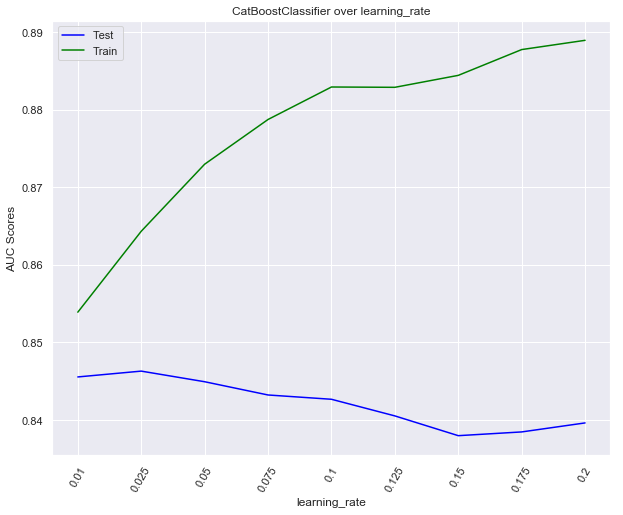

In [12]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=700
)

parameters = {'learning_rate': [0.01, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]}

grid_classifier(model, train_x, train_y, parameters)

#### Max Depth
Could pick default of None or 6 which has same AUC, going with 6

Seconds to fit: 2132.65
Grid Scores: 

{'mean_fit_time': array([155.19957576, 157.57466536, 150.41585302, 192.29595776,
       176.76850238, 202.16736836, 259.78653135, 380.55239139]),
 'mean_score_time': array([0.0213778 , 0.01679029, 0.01863594, 0.0183322 , 0.01889606,
       0.02057605, 0.02177844, 0.02279282]),
 'mean_test_score': array([0.84698311, 0.84662189, 0.84665466, 0.84628662, 0.84680932,
       0.84650966, 0.84669623, 0.84609633]),
 'mean_train_score': array([0.85593471, 0.85867314, 0.86153381, 0.86432333, 0.86720961,
       0.86823822, 0.87096368, 0.87227527]),
 'param_max_depth': masked_array(data=[3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'max_depth': 3},
            {'max_depth': 4},
            {'max_depth': 5},
            {'max_depth': 6},
            {'max_depth': 7},
            {'max_depth': 8},
            {'max_depth': 9},
            {'max

GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a19114320>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_depth': range(3, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

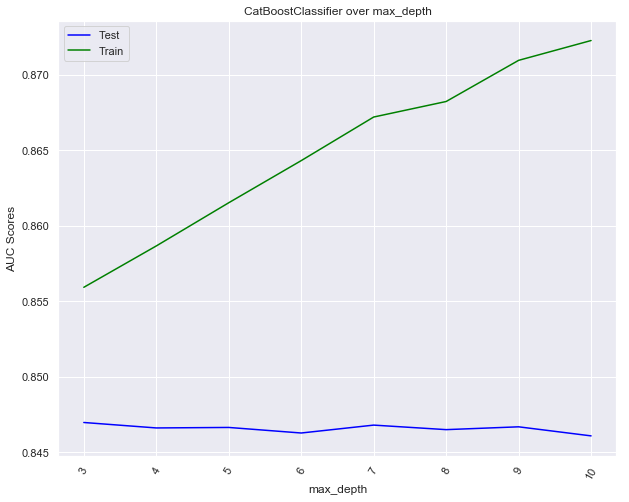

In [13]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=700,
    learning_rate=0.025
)

parameters = {'max_depth': range(3, 11)}

grid_classifier(model, train_x, train_y, parameters)

#### L2 Leaf Reg
Sticking with default of None

Seconds to fit: 2146.74
Grid Scores: 

{'mean_fit_time': array([190.59839201, 170.81801558, 167.24259706, 169.0604548 ,
       164.10678387, 167.54968748, 176.52469721, 166.56880927,
       161.93475862, 131.79862151]),
 'mean_score_time': array([0.0226233 , 0.01965418, 0.01862836, 0.01943502, 0.0185174 ,
       0.0210794 , 0.01868968, 0.0195282 , 0.01818023, 0.01711745]),
 'mean_test_score': array([0.84735174, 0.84683387, 0.84680932, 0.84636318, 0.84677603,
       0.84631376, 0.84642163, 0.84672569, 0.84623311, 0.84668105]),
 'mean_train_score': array([0.8677112 , 0.8664312 , 0.86720961, 0.86639737, 0.86620842,
       0.86608477, 0.86573401, 0.86588934, 0.86639781, 0.86534689]),
 'param_l2_leaf_reg': masked_array(data=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             mask=[False, False, False, False, False, False, False, False,
                   False, False],
       fill_value='?',
            dtype=object),
 'params': [{'l2_leaf_reg': 1},
            {'l2_leaf_reg': 2},
            {'l

GridSearchCV(cv=5, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x1a1dd9e240>,
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'l2_leaf_reg': range(1, 11)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

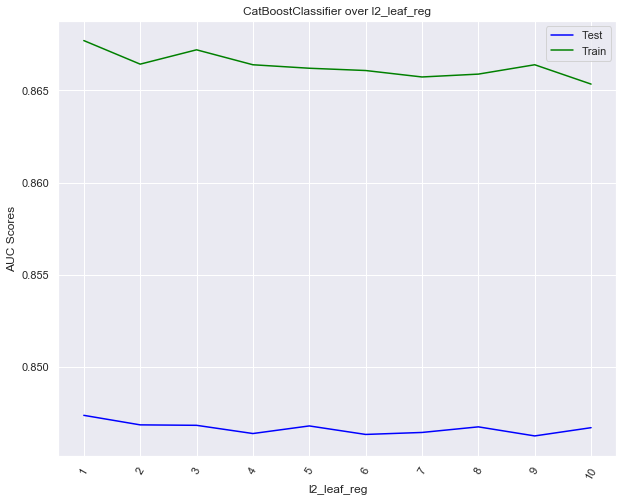

In [5]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=700,
    learning_rate=0.025,
    max_depth=7,
)

parameters = {'l2_leaf_reg': range(1, 11)}

grid_classifier(model, train_x, train_y, parameters)

#### Final CatBoost Model

In [7]:
model = CatBoostClassifier(
    random_state=42,
    cat_features=cat_cols,
    verbose=False,
    n_estimators=700,
    learning_rate=0.025,
    max_depth=7,
    l2_leaf_reg=1
)

gsearch = grid_classifier(model, test_x, test_y, verbose=False)

Seconds to fit: 194.60
AUC: 0.85413
